# GeneFormer perturb seq benchmark

In [1]:
from scdataloader import Preprocessor

from bengrn import BenGRN, get_perturb_gt

from grnndata import utils as grnutils
from anndata.utils import make_index_unique
import pandas as pd
import numpy as np
import pandas as pd
import scanpy as sc

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

→ connected lamindb: jkobject/scprint


In [2]:
import shutil
import os

from geneformer import EmbExtractor
from geneformer import TranscriptomeTokenizer
from grnndata import GRNAnnData

from geneformer import TOKEN_DICTIONARY_FILE
import pickle

with open(TOKEN_DICTIONARY_FILE, "rb") as f:
    gene_mapping_dict = pickle.load(f)

def compute_geneformer_network(adata, model="../../Geneformer/gf-12L-30M-i2048/", model_type="Pretrained", forward_batch_size=4, max_ncells=1000, cache=False):
    if cache and os.path.exists("/tmp/geneformer/test.h5ad"):
        adata = sc.read_h5ad("/tmp/geneformer/test.h5ad")
    else:
        adata = adata[:, adata.var.index.isin([u for u in gene_mapping_dict.keys() if u in adata.var.index])]
        adata.var['ensembl_id'] = adata.var.index
        adata.obs['n_counts'] = adata.X.sum(1)
        # Create the geneformer folder if it doesn't exist
        geneformer_folder = "/tmp/geneformer"
        if not os.path.exists(geneformer_folder):
            os.makedirs(geneformer_folder)
        adata.write_h5ad("/tmp/geneformer/test.h5ad")

    genelist = [gene_mapping_dict[u] for u in adata.var.index]

    tokenized_data_path = "/tmp/geneformer/tokenized_data.dataset/"
    if os.path.exists(tokenized_data_path):
        shutil.rmtree(tokenized_data_path)
    tk = TranscriptomeTokenizer(nproc=16, model_input_size=2048)
    tk.tokenize_data("/tmp/geneformer/", 
                    "/tmp/geneformer/",
                    "tokenized_data", 
                    file_format="h5ad")
    embex = EmbExtractor(model_type=model_type, #CellClassifier
                     max_ncells=max_ncells,
                     emb_mode="cell",
                     forward_batch_size=forward_batch_size,
                     nproc=16,
                     genelist=genelist)
    embs, avg_attentions = embex.extract_embs(model, #../../../Geneformer/fine_tuned_models/gf-6L-30M-i2048_CellClassifier_cardiomyopathies_220224/
                          "/tmp/geneformer/tokenized_data.dataset/",
                          "/tmp/geneformer",
                          "geneformertest",
                          get_avg_attentions=True,
                          )
    return GRNAnnData(adata.copy(), grn=avg_attentions.to("cpu").numpy())

ModuleNotFoundError: No module named 'geneformer'

In [3]:
adata = get_perturb_gt()

adata.var["isTF"] = False
adata.var.loc[adata.var.gene_name.isin(grnutils.TF), "isTF"] = True
adata.var["isTF"].sum()

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:626: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_sc.obs["organism_ontology_term_id"] = "NCBITaxon:9606"


650

In [4]:
#genes = torch.load('/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/scprint_scale/o2uniqsx/checkpoints/epoch=18-step=133000.ckpt', map_location=torch.device('cpu'))['hyper_parameters']['genes']

genes = torch.load('../data/temp/vbd8bavn/epoch=17-step=90000.ckpt')['hyper_parameters']['genes']

In [5]:
preprocessor = Preprocessor(force_preprocess=True, skip_validate=True,
                            do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)
nadata = preprocessor(adata.copy())
NUM_GENES = 5000
NUM_CELLS = 1024
adata

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 10691 renamining
filtered out 0 cells, 10691 renamining
Removed 1 genes.
startin QC
Seeing 10066 outliers (94.15% of total dataset):


/home/ml4ig1/Documents code/scDataLoader/scdataloader/preprocess.py:350: ImplicitModificationWarning: Trying to modify index of attribute `.obs` of view, initializing view as actual.
  adata.obs.index = [str(uuid4()) for _ in range(adata.shape[0])]


done


GRnnData object with n_obs × n_vars = 10691 × 8563
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count', 'organism_ontology_term_id'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'isTF'
    varp: 'GRN'
    with a grn of 1115065 elements

In [6]:
adata.var['symbol'] = adata.var["gene_name"]
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:NUM_CELLS, adata.var.index.isin(
    genes) & adata.var.index.isin(gene_mapping_dict.keys())]
sc.pp.highly_variable_genes(subadata, flavor="seurat_v3", n_top_genes=NUM_GENES)
subadata = subadata[:, subadata.var.highly_variable]
del subadata.varp['GRN']
metrics = {}
subadata

/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:172: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}
/tmp/ipykernel_270586/935268621.py:7: ImplicitModificationWarning: Removing element `.varp['GRN']` of view, initializing view as actual.
  del subadata.varp['GRN']


AnnData object with n_obs × n_vars = 1024 × 5000
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count', 'organism_ontology_term_id'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'isTF', 'symbol', 'ensembl_id', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

In [7]:
(subadata.X.sum(0)>0).sum()

5000

In [8]:
grn = compute_geneformer_network(subadata)

/tmp/ipykernel_270586/3666961077.py:19: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['ensembl_id'] = adata.var.index


Tokenizing /tmp/geneformer/test.h5ad
/tmp/geneformer/test.h5ad has no column attribute 'filter_pass'; tokenizing all cells.


/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:473: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for i in adata.var["ensembl_id_collapsed"][coding_miRNA_loc]
/home/ml4ig1/Documents code/Geneformer/geneformer/tokenizer.py:476: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coding_miRNA_ids = adata.var["ensembl_id_collapsed"][coding_miRNA_loc]


Creating dataset.


BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is N

  0%|          | 0/250 [00:00<?, ?it/s]

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


# transpose

precision:  0.022950676866967498 
recall:  1.0 
random precision: 0.02295525771821031


 98%|█████████▊| 125/128 [00:05<00:00, 20.75it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:06<00:00, 21.19it/s]


Average Precision (AP):  0.024824265534907738
Area Under Precision-Recall Curve (AUPRC):  0.024813718307774263
EPR: 0.8988715358166439


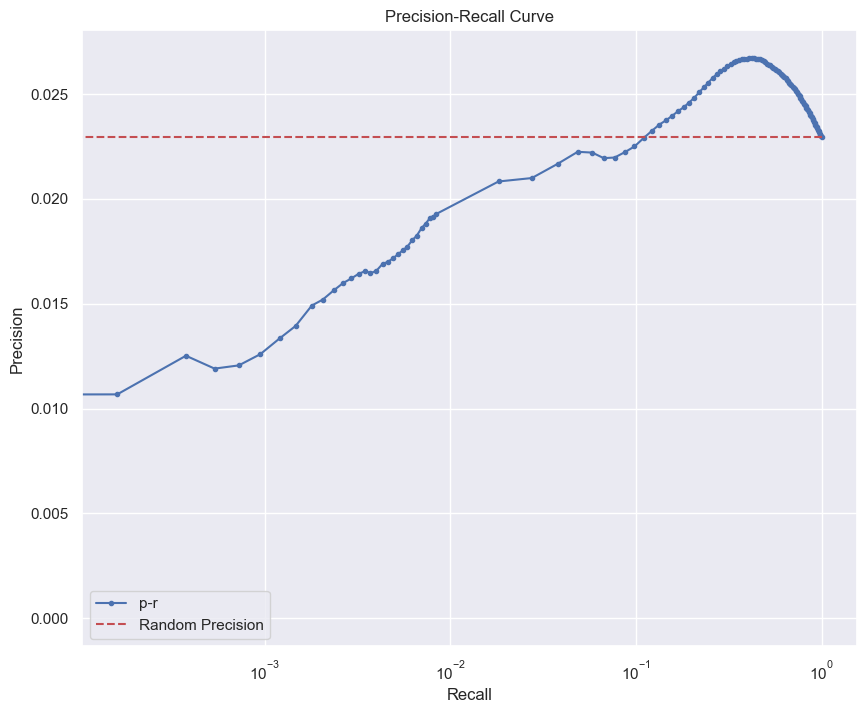

In [9]:
grn.varp["GRN"] = grn.varp["GRN"].T
metrics['geneformer_perturb'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=adata)

base enrichment
Top central genes: []


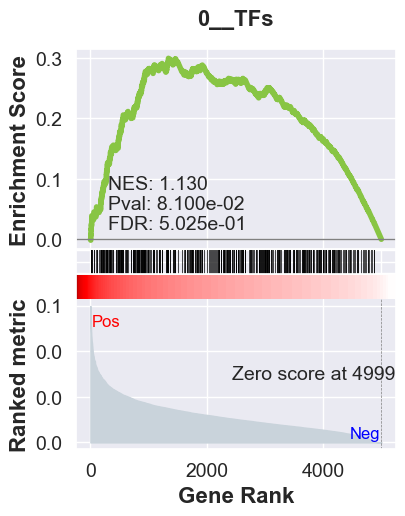

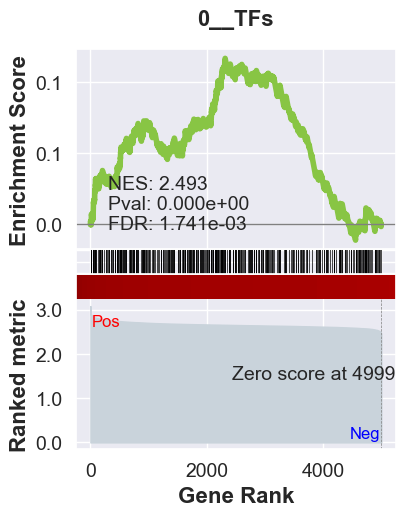

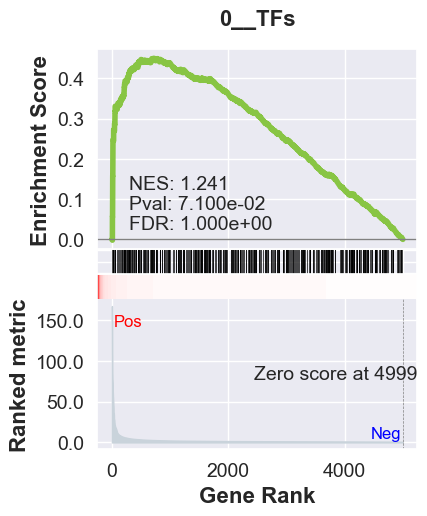

_________________________________________
TF specific enrichment
found some significant results for  5.882352941176471 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3491 genes
intersection pct: 0.6982
precision:  0.0015271855762562746 
recall:  1.0 
random precision: 0.0015275739317236303


 98%|█████████▊| 126/128 [00:02<00:00, 55.41it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:02<00:00, 54.99it/s]


Average Precision (AP):  0.0017956811055263614
Area Under Precision-Recall Curve (AUPRC):  0.0017959948377614175
EPR: 0.17532587076584297


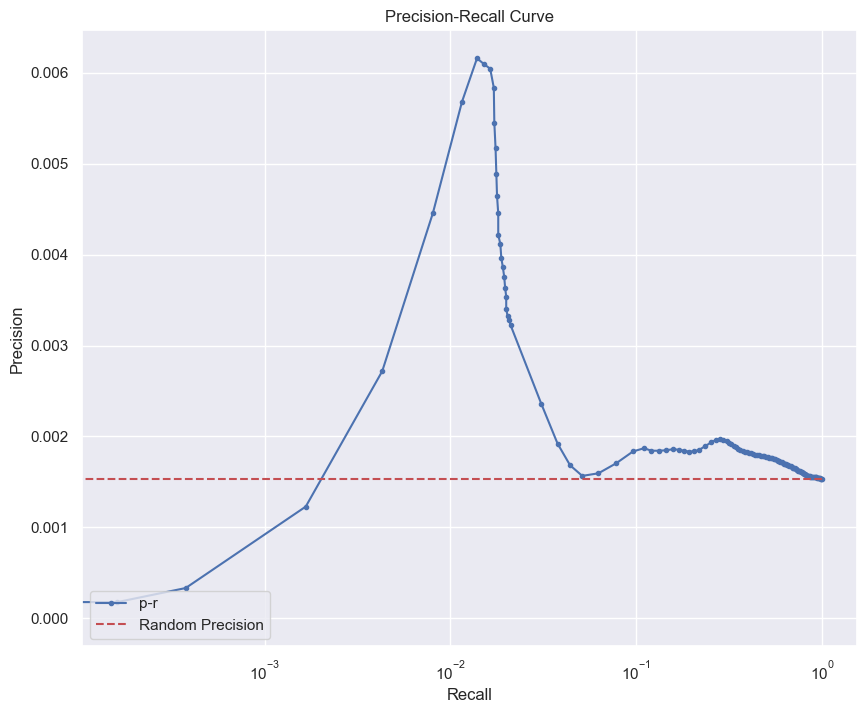

In [10]:
grn.var.index = make_index_unique(grn.var['symbol'].astype(str))
metrics['geneformer_perturb_base'] = BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

# Normal

precision:  0.022950676866967498 
recall:  1.0 
random precision: 0.02295525771821031


 98%|█████████▊| 126/128 [00:05<00:00, 22.13it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:05<00:00, 22.13it/s]


Average Precision (AP):  0.02426638262906394
Area Under Precision-Recall Curve (AUPRC):  0.02426901724376178
EPR: 0.7903204569524879


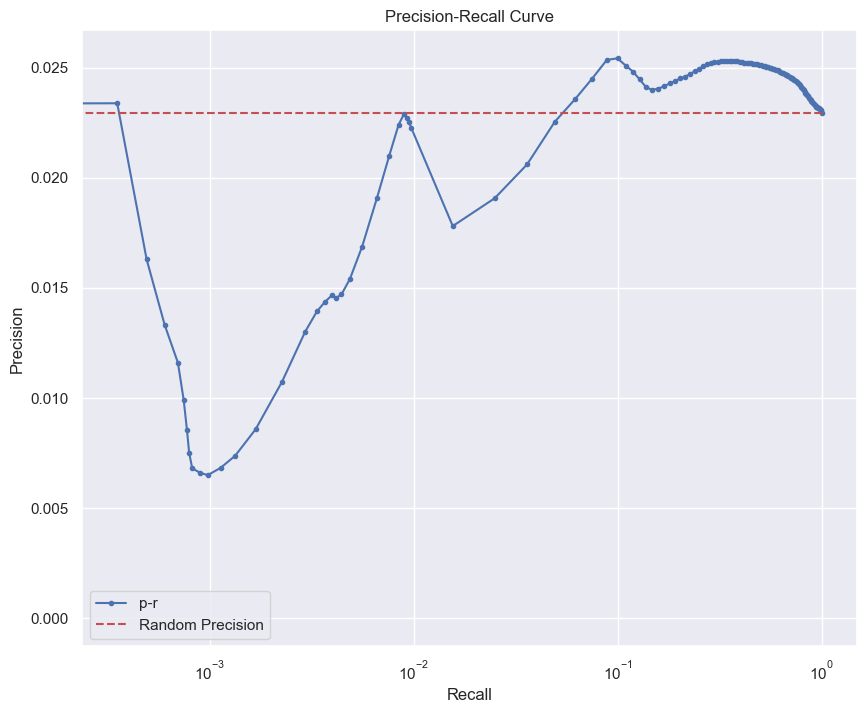

In [11]:
grn.varp["GRN"] = grn.varp["GRN"].T
grn.var.index = grn.var.ensembl_id
metrics['geneformer_perturb_transp'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=adata)

# on TF only

In [12]:
# Set non-TF connections to 0
non_tf_mask = ~grn.var['isTF'].values
# Set connections to non-TFs to 0
grn.varp['GRN'][non_tf_mask, :] = 0

non_tf_mask = ~adata.var['isTF'].values
adata.varp['GRN'][non_tf_mask, :] = 0

/home/ml4ig1/miniconda3/envs/geneformer/lib/python3.10/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


precision:  0.01765700934579439 
recall:  1.0 
random precision: 0.01766054145408521


 98%|█████████▊| 126/128 [00:00<00:00, 416.43it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:860: RuntimeWarning: invalid value encountered in scalar divide
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 128/128 [00:00<00:00, 413.86it/s]


Average Precision (AP):  0.018056693832881176
Area Under Precision-Recall Curve (AUPRC):  0.018052859217523858
EPR: 0.6725096940310664


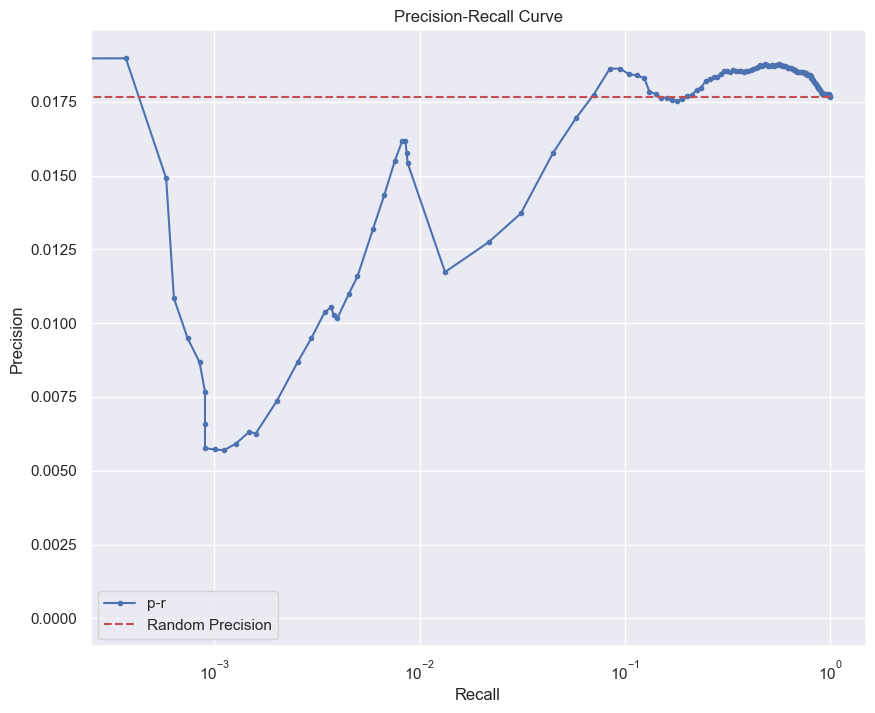

In [13]:
grn.var.index = grn.var.ensembl_id
metrics['geneformer_tf_perturb'] = BenGRN(grn, do_auc=True, doplot=True).compare_to(other=adata)

In [14]:
metrics

{'geneformer_perturb': {'precision': 0.022950676866967498,
  'recall': 1.0,
  'rand_precision': 0.02295525771821031,
  'auprc': 0.024813718307774263,
  'ap': 0.024824265534907738,
  'epr': 0.8988715358166439},
 'geneformer_perturb_base': {'enriched_terms_Central': ['celltype.gmt__Hepatic stellate cells',
   'celltype.gmt__Non-classical monocytes',
   'celltype.gmt__Microfold cells',
   'celltype.gmt__Microglial cells',
   'celltype.gmt__Alveolar macrophages'],
  'TF_enr': True,
  'enriched_terms_Regulators': ['0__TFs',
   'celltype.gmt__Non-classical monocytes',
   'celltype.gmt__Mesangial cells',
   'celltype.gmt__Radial glial cells',
   'celltype.gmt__Microfold cells',
   'celltype.gmt__Paneth cells',
   'celltype.gmt__Epiblast cells',
   'celltype.gmt__Langerhans cells',
   'celltype.gmt__Merkel cells',
   'celltype.gmt__Hepatic stellate cells',
   'celltype.gmt__Podocytes',
   'celltype.gmt__Embryonic stem cells',
   'celltype.gmt__Microglial cells',
   'celltype.gmt__Enteroendocri

In [15]:
res = []
res2 = []
for k, v in metrics.items():
    if k.split('_')[-1] == "base":
        res2.append([k.split('_')[-2], v['epr'], v['auprc'], v['rand_precision'], v['significant_enriched_TFtargets'], v.get('TF_enr', False), 'tf_' in k])
    else:
        res.append([k.split('_')[-1], v['epr'], v['auprc'], v['rand_precision'], 'tf_' in k])

df = pd.DataFrame(res, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_only'])
df2 = pd.DataFrame(res2, columns=['name','EPR', 'AUPRC', 'RAND', 'TF_targ', 'TF_enr', 'TF_only'])
df

,name,EPR,AUPRC,RAND,TF_only
0,perturb,0.898872,0.024814,0.022955,False
1,transp,0.790320,0.024269,0.022955,False
2,perturb,0.672510,0.018053,0.017661,True


In [16]:
df2

,name,EPR,AUPRC,RAND,TF_targ,TF_enr,TF_only
0,perturb,0.175326,0.001796,0.001528,5.882353,True,False
